This notebook is intended to serve as an introduction to transfer learning as a method of classifying chest x-rays into 3 categories (COVID-19, viral pneumonia, normal). The goal here is to introduce the concept of deep learning as a way to classify chest x-rays and in particular for patients with COVID-19. The models produced here are not intended to substitute for an impression given by an expert radiologist. Rather it may serve as a foundation for those who are interested in applications of deep learning in medicine for triaging, diagnosis, prognosis, and treatment.

It should be noted that there are many limitations associated with such a model, including using only 3 classes of CXRs. It is also impossible to accurately predict the distribution of CXRs that you will obtain in a real clinical setting. 

The dataset we are using is the Covid-19 Radiography Database which is publically available on Kaggle at this url, https://www.kaggle.com/tawsifurrahman/covid19-radiography-database. Please refer to this url for details regarding the dataset. The following reference is provided to give credit to the team responsible for organizing the dataset.

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145. https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

It should be noted that some of the normal and viral pneumonia chest x-ray images are obtained from existing datasets on Kaggle.

Please feel free to share this notebook as you like, and give me credit if you do so. If you like what you see here, you can check out my Kaggle profile. You can also follow me on Twitter [@leoyuguanall38](https://twitter.com/leoyuguanall38). Please also check out my [GitHub profile](https://github.com/leoyuguanall38).

Let's start with imports:

In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

Set constants and hyperparameter values:

In [2]:
LR = 0.0001
EPOCHS = 7
BATCH_SIZE = 32
IMG_SIZE = 224

Obtain list of image paths. Last line is to verify number of image paths obtained matches number of expected images for our dataset.

In [3]:
imagePaths = []

for dirname, _, filenames in os.walk('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

#Should return true for our dataset.
len(imagePaths) == 219+1341+1345

True

Use the following code to view sample images from the dataset.

/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19/COVID-19 (100).png
(1024, 1024, 3)


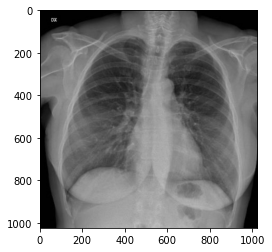

In [4]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

Use the following code to convert list of image paths to ndarrays containing image data and labels.

In [5]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(2905, 224, 224, 3) (2905,)


     Labels
0  COVID-19
1  COVID-19
2  COVID-19
3  COVID-19
4  COVID-19 

Viral Pneumonia    1345
NORMAL             1341
COVID-19            219
Name: Labels, dtype: int64


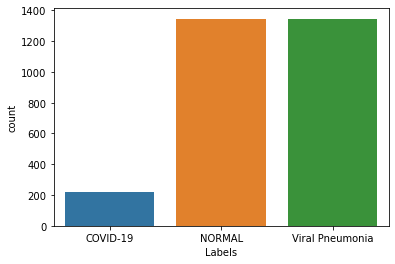

In [6]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

Let's convert the label list to a one hot format.

In [7]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [8]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]] 

[1. 0. 0.] 

<class 'numpy.ndarray'> 

['COVID-19' 'NORMAL' 'Viral Pneumonia'] 



In [9]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(2178, 224, 224, 3)
(2178, 3)
(727, 224, 224, 3)
(727, 3)


Use the following code to design your model. In this tutorial we will focus primarily on transfer learning, although code is also provided to create your own model.

In [10]:
#Code to create custom model is provided for convenience

def my_model():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))

    return model

Code for transfer learning model. Each pre-trained model is loaded by a separate function and then added to sequential model with FC layers to produce final classification.

In [11]:
#Transfer learning with VGG16

def VGG16_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [12]:
#Transfer learning with ResNet101

def ResNet101_model():
    base_model = ResNet101(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [13]:
#Transfer learning with Xception

def Xception_model():
    base_model = Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [14]:
covid_model = Sequential()
covid_model.add(VGG16_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(3, activation='sigmoid'))

covid_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 25088)             14714688  
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 27,593,283
Trainable params: 12,878,595
Non

In [15]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

Epoch 1/7
68/68 [==============================] - 29s 429ms/step - loss: 0.4526 - accuracy: 0.7992 - val_loss: 0.2524 - val_accuracy: 0.8693
Epoch 2/7
68/68 [==============================] - 27s 402ms/step - loss: 0.2456 - accuracy: 0.8733 - val_loss: 0.1860 - val_accuracy: 0.9147
Epoch 3/7
68/68 [==============================] - 27s 398ms/step - loss: 0.1783 - accuracy: 0.9292 - val_loss: 0.1397 - val_accuracy: 0.9505
Epoch 4/7
68/68 [==============================] - 27s 397ms/step - loss: 0.1522 - accuracy: 0.9483 - val_loss: 0.1241 - val_accuracy: 0.9560
Epoch 5/7
68/68 [==============================] - 26s 386ms/step - loss: 0.1269 - accuracy: 0.9497 - val_loss: 0.1117 - val_accuracy: 0.9546
Epoch 6/7
68/68 [==============================] - 28s 408ms/step - loss: 0.1108 - accuracy: 0.9623 - val_loss: 0.1506 - val_accuracy: 0.9505
Epoch 7/7
68/68 [==============================] - 27s 397ms/step - loss: 0.0834 - accuracy: 0.9716 - val_loss: 0.0926 - val_accuracy: 0.9615


Analyzing the training and validation statistics for our model.

In [16]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


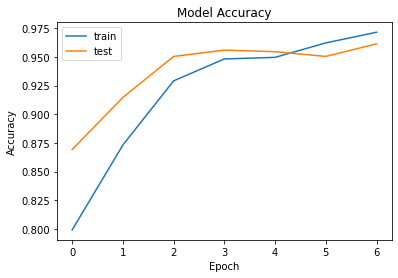

In [17]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

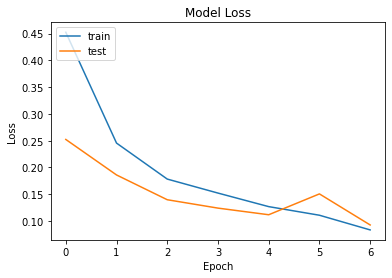

In [18]:
#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We did not set aside a separate testing dataset, so we will use the validation dataset for illustration purposes. Keep in mind that the validation dataset in this case is not a good evaluation of the accuracy of the model because it is data that the model has already seen.

In [19]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

23/23 [==============================] - 2s 102ms/step - loss: 0.0926 - accuracy: 0.9615
Model accuracy on validation dataset: 96.148556.


In [20]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[2 2 1 2 1 2 2 2 1 1 1 2 2 1 0 2 1 0 2 2 2 1 1 2 2 0 2 1 2 1 2 1 1 0 1 1 1
 1 2 0 2 1 1 2 2 1 1 2 1 2 2 2 1 1 2 2 2 1 0 1 2 2 2 1 1 0 2 2 1 1 2 1 2 2
 2 1 2 2 2 1 2 2 2 1 2 1 2 2 1 2 1 1 2 2 1 2 2 2 2 1 1 1 1 2 2 2 1 2 1 2 1
 1 1 1 1 2 2 1 0 1 2 2 2 2 1 1 1 1 2 2 1 1 1 0 2 1 1 2 1 2 2 2 2 1 2 2 2 1
 1 2 1 1 1 2 1 1 2 2 0 2 2 2 0 0 2 2 2 2 1 1 2 2 2 1 1 2 0 1 2 2 1 2 1 2 1
 2 1 1 2 2 2 2 0 1 0 2 1 1 2 2 1 1 1 2 2 1 1 2 2 0 2 0 2 2 2 2 1 2 1 2 2 1
 2 1 2 2 0 2 2 1 1 2 1 1 2 0 0 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1 0 2 2 1 1 1 2
 1 1 1 2 1 2 1 2 1 1 2 1 2 1 2 2 1 1 2 1 1 1 2 2 1 1 2 1 2 2 1 0 1 1 2 2 0
 2 2 0 1 1 2 2 2 2 2 2 1 2 1 1 2 2 1 2 2 2 2 2 2 2 1 2 1 1 2 2 2 1 2 1 0 2
 2 1 2 2 2 0 2 1 1 2 2 1 1 1 1 1 0 2 0 1 2 1 1 1 1 2 2 1 2 2 1 1 0 1 2 2 2
 1 1 2 2 2 2 1 1 1 2 0 1 2 1 2 1 1 2 1 1 1 2 2 0 1 1 1 2 1 2 1 1 2 1 0 1 1
 2 2 2 2 2 1 1 2 1 1 1 2 2 1 1 1 2 1 1 1 2 2 1 1 1 2 1 1 1 2 2 2 2 2 1 1 1
 1 2 1 2 2 0 2 2 1 1 1 2 1 1 2 1 2 1 2 2 1 2 2 2 2 1 2 1 1 1 2 1 2 1 1 2 1
 1 2 1 2 2 2 2 2 2 2 1 1 

In [21]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[2 2 1 2 1 2 1 2 1 1 1 2 2 1 0 2 1 0 2 2 2 1 1 1 2 0 2 1 2 1 2 1 1 0 1 1 1
 0 2 2 2 1 1 2 2 1 1 2 1 2 2 2 1 1 1 2 2 1 0 1 2 2 2 1 1 0 0 2 1 1 2 1 2 2
 2 1 2 2 2 1 2 2 2 1 2 1 2 2 1 2 1 1 2 2 1 2 2 2 2 1 1 1 1 2 2 2 1 2 1 2 1
 1 1 1 1 2 2 1 2 1 2 2 2 2 1 1 1 1 2 2 1 1 1 0 2 1 1 2 1 2 2 2 2 1 2 2 2 1
 1 2 1 1 1 2 1 1 2 2 0 2 2 2 0 0 2 2 2 2 1 1 2 2 2 1 1 2 0 1 2 2 1 2 1 2 1
 2 1 1 2 2 2 2 0 1 0 2 1 1 2 2 1 1 1 2 2 1 1 2 2 0 2 0 2 2 2 2 1 2 1 2 2 1
 2 1 2 2 0 2 2 1 1 2 1 1 2 0 0 1 2 1 1 2 1 1 1 1 2 2 2 2 1 1 0 2 2 1 1 1 2
 1 1 1 2 1 2 1 2 1 1 2 1 2 1 2 2 1 1 2 1 1 1 2 2 1 1 2 1 2 2 1 0 1 1 2 2 0
 2 2 0 1 1 2 2 2 2 2 2 1 2 1 1 2 2 1 2 2 2 2 2 2 2 1 0 1 1 2 2 2 1 2 1 0 2
 1 1 2 1 2 0 2 1 1 2 2 1 1 1 1 1 0 2 0 1 2 1 1 1 1 2 2 1 2 2 1 1 0 1 2 2 2
 1 1 2 2 2 2 1 1 1 2 0 1 2 1 2 1 1 2 1 1 1 2 2 0 1 1 1 2 1 2 1 1 1 1 0 1 1
 2 2 2 2 2 1 1 2 1 1 1 2 2 1 1 1 2 1 2 1 2 2 1 2 1 2 1 1 1 2 2 2 2 2 2 1 1
 1 2 1 2 2 0 2 2 1 1 1 2 1 1 2 1 1 1 2 2 1 2 2 2 2 1 2 1 1 1 2 1 2 1 1 2 1
 1 2 1 2 2 2 2 2 2 2 1 1 

We will use a confusion matrix to better visualize our predicted vs true values for the validation data.

In [22]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[ 52   1   2]
 [  0 321  14]
 [  3   8 326]]


,COVID-19,NORMAL,Viral Pneumonia
COVID-19,52,1,2
NORMAL,0,321,14
Viral Pneumonia,3,8,326


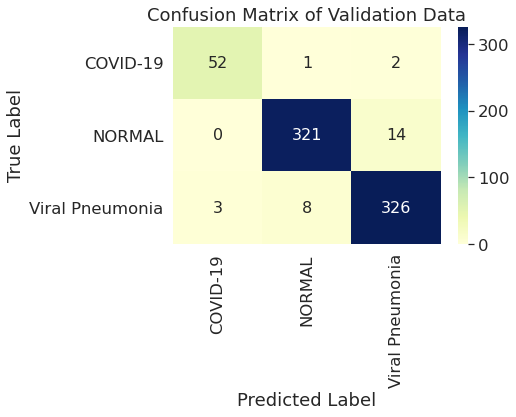

In [23]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

Save model weights for future use.

In [24]:
covid_model.save('covid_model_v1')

A few summary and learning points.

* This model appears to have high specificity for COVID-19. That is, if the model predicts COVID-19, there is actually a 100% chance that it is COVID-19. Another way to phrase this is that if the image is not COVID-19, there is a 100% chance that the model will predict it is not COVID-19.
* Theoretically speaking, if such a model were to be implemented in a clinical setting, it may be helpful in that if it gives a prediction of COVID-19 to a chest X-ray, special attention should be paid to the image as there's a good chance it may represent an actual case of COVID-19.
* The prevalence of COVID-19 in a particular patient population is important for designing a good training set, but it is very difficult to determine. 
* COVID-19 images may be misinterpreted as viral pneumonia, which makes sense. However, no viral pneumonia images are mislabeled as COVID-19.

Thank you for checking out this notebook. Check out my [Twitter](https://twitter.com/leoyuguanall38) and [GitHub profile](https://github.com/leoyuguanall38) if you like what you see here.